In [1]:
import requests
import pandas as pd
from io import StringIO
import datetime
import time

## 讀取台股股價資料

In [2]:
def get_year_month_str_from(year,month):
    year_month_arr = []
    today=datetime.datetime.today()
    while True:
        year_month_arr.append('%d%02d01' % (year,month))
        if year == today.year and month == today.month:
            break
        if month == 12:
            year += 1
            month = 1
        else:
            month += 1
    return year_month_arr

### 爬取2017年開始每日資料

In [3]:
year_month_str = get_year_month_str_from(2017,1)

In [4]:
def transform_date(date):   #民國轉西元
        y, m, d = date.split('/')
        return str(int(y)+1911) + '/' + m  + '/' + d
    
def transform_value(data):   #將證交所獲得資料進行資料格式轉換
    data[0] = datetime.datetime.strptime(transform_date(data[0]), '%Y/%m/%d')
    data[1] = int(data[1].replace(',', ''))#把千進位的逗點去除
    data[2] = int(data[2].replace(',', ''))
    data[3] = float(data[3].replace(',', ''))
    data[4] = float(data[4].replace(',', ''))
    data[5] = float(data[5].replace(',', ''))
    data[6] = float(data[6].replace(',', ''))
    data[7] = float(0.0 if data[7].replace(',', '') == 'X0.00' else data[7].replace(',', ''))  # +/-/X表示漲/跌/不比價
    data[8] = int(data[8].replace(',', ''))
    return data
def transform(data):   #讀取每一個元素進行資料格式轉換，再產生新的串列
    return [transform_value(d) for d in data]

In [5]:
STOCK_NO='2330'

In [6]:
df = pd.DataFrame()
for datetimeStr in year_month_str:
    url = "http://www.twse.com.tw/exchangeReport/STOCK_DAY"
    params = {}
    params['stockNo'] = STOCK_NO
    params['date'] = datetimeStr
    r = requests.get(url, params=params)
    df = df.append(pd.DataFrame(transform(r.json()['data']),columns=r.json()['fields']),ignore_index = True)
    time.sleep(3)

In [7]:
df['漲跌幅'] = df['收盤價'].pct_change().map(lambda x: x*100)
df.columns

Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       '漲跌幅'],
      dtype='object')

In [8]:
df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,漲跌幅
0,2017-01-03,23550783,4300648272,181.5,183.5,181.0,183.0,1.5,8743,NaN
1,2017-01-04,24482374,4478699942,183.0,184.0,181.5,183.0,0.0,8476,0.000000
2,2017-01-05,21373561,3913389163,182.0,183.5,181.5,183.5,0.5,8297,0.273224
3,2017-01-06,23120808,4250912732,184.0,184.5,183.5,184.0,0.5,9659,0.272480
4,2017-01-09,18583788,3419409204,184.0,185.0,183.0,184.0,0.0,5759,0.000000


In [9]:
all_data = df.loc[:,['開盤價','最高價','最低價','收盤價','成交筆數','漲跌幅']]
all_data.head()

,開盤價,最高價,最低價,收盤價,成交筆數,漲跌幅
0,181.5,183.5,181.0,183.0,8743,NaN
1,183.0,184.0,181.5,183.0,8476,0.000000
2,182.0,183.5,181.5,183.5,8297,0.273224
3,184.0,184.5,183.5,184.0,9659,0.272480
4,184.0,185.0,183.0,184.0,5759,0.000000


In [10]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
sc_percentage = MinMaxScaler(feature_range = (-1, 1))
all_data.loc[:, all_data.columns != '漲跌幅'] = sc.fit_transform(all_data.loc[:, all_data.columns != '漲跌幅'])
all_data.loc[1:,['漲跌幅']] = sc_percentage.fit_transform(all_data.loc[1:,['漲跌幅']])
all_data.head()

,開盤價,最高價,最低價,收盤價,成交筆數,漲跌幅
0,0.022099,0.033520,0.022599,0.039106,0.169314,NaN
1,0.038674,0.039106,0.028249,0.039106,0.163416,0.077404
2,0.027624,0.033520,0.028249,0.044693,0.159462,0.120936
3,0.049724,0.044693,0.050847,0.050279,0.189547,0.120817
4,0.049724,0.050279,0.045198,0.050279,0.103400,0.077404


In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(data.shape[1])]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(data.shift(-i))
        if i == 0:
             names += [('%s(t)' % data.columns[j]) for j in range(data.shape[1])]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(data.shape[1])]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
TIME_STEP = 20

In [13]:
supervised_data_all_columns = series_to_supervised(all_data,TIME_STEP)
supervised_data = supervised_data_all_columns.drop(supervised_data_all_columns.columns[[-2,-3,-4,-5,-6]], axis=1)
supervised_data.head()

,開盤價(t-20),最高價(t-20),最低價(t-20),收盤價(t-20),成交筆數(t-20),漲跌幅(t-20),開盤價(t-19),最高價(t-19),最低價(t-19),收盤價(t-19),...,收盤價(t-2),成交筆數(t-2),漲跌幅(t-2),開盤價(t-1),最高價(t-1),最低價(t-1),收盤價(t-1),成交筆數(t-1),漲跌幅(t-1),漲跌幅(t)
21,0.038674,0.039106,0.028249,0.039106,0.163416,0.077404,0.027624,0.033520,0.028249,0.044693,...,0.055866,0.168629,0.077404,0.044199,0.044693,0.045198,0.044693,0.158313,-0.008951,0.120817
22,0.027624,0.033520,0.028249,0.044693,0.159462,0.120936,0.049724,0.044693,0.050847,0.050279,...,0.044693,0.158313,-0.008951,0.049724,0.055866,0.050847,0.050279,0.122838,0.120817,0.207289
23,0.049724,0.044693,0.050847,0.050279,0.189547,0.120817,0.049724,0.050279,0.045198,0.050279,...,0.050279,0.122838,0.120817,0.055249,0.055866,0.056497,0.067039,0.187493,0.207289,0.249183
24,0.049724,0.050279,0.045198,0.050279,0.103400,0.077404,0.055249,0.055866,0.050847,0.050279,...,0.067039,0.187493,0.207289,0.077348,0.083799,0.084746,0.089385,0.199819,0.249183,0.077404
25,0.055249,0.055866,0.050847,0.050279,0.149168,0.077404,0.060773,0.050279,0.028249,0.027933,...,0.089385,0.199819,0.249183,0.104972,0.106145,0.096045,0.089385,0.228292,0.077404,0.204864


## 將資料分為訓練用及測試用

In [14]:
train_size = round(len(supervised_data)*0.8)
print(train_size)
values = supervised_data.values
train = values[:train_size, :]
test = values[train_size:, :]
test_size = len(test)
print(test_size)

511
128


In [15]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_size, TIME_STEP, 6))
test_X = test_X.reshape((test_size, TIME_STEP, 6))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X.shape[1])
print(train_X.shape[2])

(511, 20, 6) (511,) (128, 20, 6) (128,)
20
6


In [16]:
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib 
import matplotlib.pyplot as plt

Using TensorFlow backend.


## 建立lstm模型

In [17]:
model = Sequential()
# input_shape(timestep,dim)
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50))
# model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

W0911 20:45:30.533166 15000 deprecation_wrapper.py:119] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0911 20:45:30.550167 15000 deprecation_wrapper.py:119] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0911 20:45:30.553169 15000 deprecation_wrapper.py:119] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0911 20:45:30.780198 15000 deprecation_wrapper.py:119] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## 訓練模型

In [18]:
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2)

W0911 20:45:30.991166 15000 deprecation.py:323] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0911 20:45:31.544195 15000 deprecation_wrapper.py:119] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0911 20:45:31.630167 15000 deprecation_wrapper.py:119] From C:\Users\Bigtongue\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 511 samples, validate on 128 samples
Epoch 1/100
 - 2s - loss: 0.1707 - val_loss: 0.1895
Epoch 2/100
 - 0s - loss: 0.1669 - val_loss: 0.1793
Epoch 3/100
 - 0s - loss: 0.1639 - val_loss: 0.1792
Epoch 4/100
 - 0s - loss: 0.1634 - val_loss: 0.1835
Epoch 5/100
 - 0s - loss: 0.1659 - val_loss: 0.1788
Epoch 6/100
 - 0s - loss: 0.1634 - val_loss: 0.1789
Epoch 7/100
 - 0s - loss: 0.1669 - val_loss: 0.1980
Epoch 8/100
 - 0s - loss: 0.1638 - val_loss: 0.1785
Epoch 9/100
 - 0s - loss: 0.1641 - val_loss: 0.1813
Epoch 10/100
 - 0s - loss: 0.1634 - val_loss: 0.1806
Epoch 11/100
 - 0s - loss: 0.1637 - val_loss: 0.1877
Epoch 12/100
 - 0s - loss: 0.1646 - val_loss: 0.1854
Epoch 13/100
 - 0s - loss: 0.1650 - val_loss: 0.1787
Epoch 14/100
 - 0s - loss: 0.1634 - val_loss: 0.1889
Epoch 15/100
 - 0s - loss: 0.1638 - val_loss: 0.1801
Epoch 16/100
 - 0s - loss: 0.1646 - val_loss: 0.1798
Epoch 17/100
 - 0s - loss: 0.1642 - val_loss: 0.1820
Epoch 18/100
 - 0s - loss: 0.1632 - val_loss: 0.1842
Epoch 19/

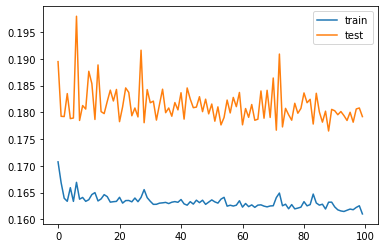

In [19]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

模型表現不佳

In [20]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                11400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
from sklearn.metrics import mean_squared_error
predict_y = model.predict(test_X)
test_y = test_y.reshape((len(test_y), 1))
# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(test_y, predict_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.227


In [22]:
predict_y

array([[ 0.09110454],
       [ 0.0622227 ],
       [ 0.04507317],
       [ 0.06501195],
       [ 0.0831067 ],
       [ 0.06178121],
       [ 0.07034807],
       [ 0.07447404],
       [ 0.07208882],
       [ 0.07467674],
       [ 0.07939738],
       [ 0.09957454],
       [ 0.078901  ],
       [ 0.09281091],
       [ 0.07974473],
       [ 0.06852899],
       [ 0.07791153],
       [ 0.06105274],
       [ 0.05570625],
       [ 0.04333349],
       [ 0.04780322],
       [ 0.05897228],
       [ 0.0705906 ],
       [ 0.06303617],
       [ 0.05299675],
       [ 0.06608231],
       [ 0.06823085],
       [ 0.06482244],
       [ 0.07221761],
       [ 0.06087489],
       [ 0.06264368],
       [ 0.05056296],
       [ 0.05504162],
       [ 0.08523478],
       [ 0.01384543],
       [ 0.01253507],
       [ 0.01230385],
       [-0.01090782],
       [ 0.07251409],
       [ 0.01276653],
       [ 0.05128806],
       [ 0.06653686],
       [ 0.04850001],
       [ 0.09167673],
       [ 0.07707237],
       [ 0

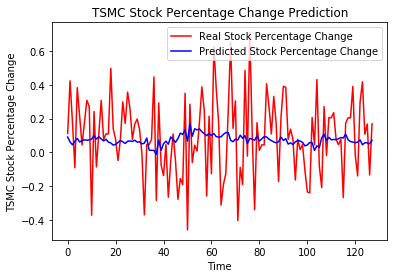

In [23]:
# Visualising the results
plt.plot(test_y, color = 'red', label = 'Real Stock Percentage Change')  # 紅線表示真實波動
plt.plot(predict_y, color = 'blue', label = 'Predicted Stock Percentage Change')  # 藍線表示預測波動
plt.title('TSMC Stock Percentage Change Prediction')
plt.xlabel('Time')
plt.ylabel('TSMC Stock Percentage Change')
plt.legend()
plt.show()

## 預測明天漲幅

In [24]:
supervised_data_future = supervised_data_all_columns.iloc[-1:,:]
future_test = supervised_data_future.iloc[:,6:].values.reshape(1,TIME_STEP,6)
yhat = model.predict(future_test)
print(f'預估{STOCK_NO}下個交易日漲幅為:{sc_percentage.inverse_transform(yhat[0][0])}')

ValueError: Expected 2D array, got scalar array instead:
array=0.06010238081216812.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.